In [34]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from fishsense_core.laser import calibrate_laser
from skimage.measure import ransac
from skimage.measure import LineModelND
from fishsense_imwut.camera import calculate_normals
from fishsense_imwut.plots import calibration_plot_position_percent_error, calibration_plot_mean_reconstruction_error, calibration_plot_mean_z_percent_error

## Setup of Simulation
The following reasonable defaults that match the systems we tested against.

In [35]:
IMAGE_WIDTH, IMAGE_HEIGHT = 4014, 3016
FOCAL_LENGTH_PX = 2850

IMAGE_WIDTH, IMAGE_HEIGHT, FOCAL_LENGTH_PX

(4014, 3016, 2850)

In [36]:
camera_intrinsics = np.array([
    [FOCAL_LENGTH_PX, 0, IMAGE_WIDTH / 2],
    [0, FOCAL_LENGTH_PX, IMAGE_HEIGHT / 2],
    [0, 0, 1]
])
inverted_camera_intrinsics = np.linalg.inv(camera_intrinsics)

camera_intrinsics, inverted_camera_intrinsics

(array([[2.850e+03, 0.000e+00, 2.007e+03],
        [0.000e+00, 2.850e+03, 1.508e+03],
        [0.000e+00, 0.000e+00, 1.000e+00]]),
 array([[ 3.50877193e-04,  0.00000000e+00, -7.04210526e-01],
        [ 0.00000000e+00,  3.50877193e-04, -5.29122807e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [37]:
laser_position = np.array([-0.04, -0.11, 0])
laser_direction = np.array([1e-10, 1e-10, 1])

laser_params = np.concatenate([laser_direction, laser_position[:2]])

laser_position, laser_direction, laser_params

(array([-0.04, -0.11,  0.  ]),
 array([1.e-10, 1.e-10, 1.e+00]),
 array([ 1.0e-10,  1.0e-10,  1.0e+00, -4.0e-02, -1.1e-01]))

## Next we setup data we can use for testing

In [38]:
STEP_COUNT = 1000
t = np.linspace(0.5, 30, STEP_COUNT)

STEP_COUNT, t

(1000,
 array([ 0.5       ,  0.52952953,  0.55905906,  0.58858859,  0.61811812,
         0.64764765,  0.67717718,  0.70670671,  0.73623624,  0.76576577,
         0.7952953 ,  0.82482482,  0.85435435,  0.88388388,  0.91341341,
         0.94294294,  0.97247247,  1.002002  ,  1.03153153,  1.06106106,
         1.09059059,  1.12012012,  1.14964965,  1.17917918,  1.20870871,
         1.23823824,  1.26776777,  1.2972973 ,  1.32682683,  1.35635636,
         1.38588589,  1.41541542,  1.44494494,  1.47447447,  1.504004  ,
         1.53353353,  1.56306306,  1.59259259,  1.62212212,  1.65165165,
         1.68118118,  1.71071071,  1.74024024,  1.76976977,  1.7992993 ,
         1.82882883,  1.85835836,  1.88788789,  1.91741742,  1.94694695,
         1.97647648,  2.00600601,  2.03553554,  2.06506507,  2.09459459,
         2.12412412,  2.15365365,  2.18318318,  2.21271271,  2.24224224,
         2.27177177,  2.3013013 ,  2.33083083,  2.36036036,  2.38988989,
         2.41941942,  2.44894895,  2.4784784

In [39]:
p = laser_position[:, np.newaxis] + t[np.newaxis, :] * laser_direction[:, np.newaxis]

p

array([[-0.04      , -0.04      , -0.04      , ..., -0.04      ,
        -0.04      , -0.04      ],
       [-0.11      , -0.11      , -0.11      , ..., -0.11      ,
        -0.11      , -0.11      ],
       [ 0.5       ,  0.52952953,  0.55905906, ..., 29.94094094,
        29.97047047, 30.        ]], shape=(3, 1000))

In [40]:
s = p / p[2, :]
s = camera_intrinsics @ s

s

array([[1.77900000e+03, 1.79171456e+03, 1.80308594e+03, ...,
        2.00319250e+03, 2.00319626e+03, 2.00320000e+03],
       [8.81000000e+02, 9.15965029e+02, 9.47236348e+02, ...,
        1.49752939e+03, 1.49753970e+03, 1.49755000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], shape=(3, 1000))

In [41]:
s_pixel = np.round(s)

s_pixel

array([[1.779e+03, 1.792e+03, 1.803e+03, ..., 2.003e+03, 2.003e+03,
        2.003e+03],
       [8.810e+02, 9.160e+02, 9.470e+02, ..., 1.498e+03, 1.498e+03,
        1.498e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 1000))

Since our laser produces a line, the projection of the laser line is itself a line in the pinhole camera model.

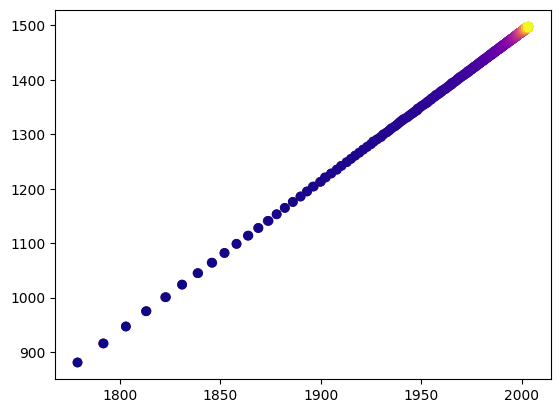

In [42]:
plt.scatter(s[0, :], s[1, :], c=p[2, :], cmap='viridis', marker='o')
plt.scatter(s_pixel[0, :], s_pixel[1, :], c=p[2, :], cmap='plasma', marker='o')

## Calibration
Below we go through calibration

In [43]:
normals = calculate_normals(p)

normals

array([[ 0.85771824,  0.1945646 ,  0.47588238],
       [-0.72840603, -0.6070528 ,  0.31766579],
       [-0.98191181,  0.15642695,  0.10667619],
       ...,
       [-0.93512886,  0.33491811,  0.11560225],
       [-0.13968815, -0.90752299,  0.39609248],
       [ 0.15638433,  0.98552139,  0.06550972]], shape=(1000, 3))

In [44]:
def point_covariance_from_uvZ(u, v, Z, K, sigma_px=1.0, sigma_Z=0.01):
    """
    Approximate 3D covariance Sigma_X for each point from pixel + depth noise.
    sigma_px: pixel std (assumed isotropic in u,v)
    sigma_Z : depth std in same units as Z (meters, etc.)

    Returns Sigmas: (N,3,3)
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    x = (u - cx) / fx
    y = (v - cy) / fy

    N = len(Z)
    Sigmas = np.zeros((N, 3, 3), dtype=float)

    for i in range(N):
        Zi = Z[i]
        xi, yi = x[i], y[i]

        # Jacobians dX/du, dX/dv, dX/dZ for X=[xZ, yZ, Z]
        Ju = np.array([Zi / fx, 0.0, 0.0])
        Jv = np.array([0.0, Zi / fy, 0.0])
        Jz = np.array([xi, yi, 1.0])

        Sigma = (sigma_px**2) * (np.outer(Ju, Ju) + np.outer(Jv, Jv)) + (sigma_Z**2) * np.outer(Jz, Jz)
        Sigmas[i] = Sigma

    return Sigmas

def fit_line_weighted_pca(X, Sigmas, iters=3, eps=1e-12):
    """
    Practical approximation:
      - compute a scalar weight per point from its 3D covariance (smaller uncertainty -> higher weight)
      - run weighted PCA
      - iterate a couple times (weights depend weakly on pose; this just stabilizes)

    Returns P,D,t,weights
    """
    P = X.mean(axis=0)
    D = np.array([0, 0, 1.0], dtype=float)

    for _ in range(iters):
        # scalar uncertainty proxy: trace
        tr = np.trace(Sigmas, axis1=1, axis2=2)
        w = 1.0 / np.maximum(tr, eps)

        wsum = w.sum()
        P = (w[:, None] * X).sum(axis=0) / wsum
        Y = X - P

        # weighted covariance
        S = (Y * w[:, None]).T @ Y
        eigvals, eigvecs = np.linalg.eigh(S)
        D = eigvecs[:, np.argmax(eigvals)]
        D = D / np.linalg.norm(D)

    scale_factor = P[2] / D[2]
    P = P - scale_factor * D

    t = (X - P) @ D
    return P, D, t, w

def weighted_pca_calibration(image_points: np.ndarray, world_points: np.ndarray, camera_intrinsics: np.ndarray, sigma_px=3.0, sigma_Z=0.01):
    Sigmas = point_covariance_from_uvZ(image_points[0, :], image_points[1, :], world_points[:, 2], camera_intrinsics, sigma_px=sigma_px, sigma_Z=sigma_Z)
    P, D, _, _ = fit_line_weighted_pca(world_points, Sigmas)

    laser_direction = D / np.linalg.norm(D)
    laser_position = P.flatten()

    scale_factor = P[2] / laser_direction[2]
    laser_position = laser_position - scale_factor * laser_direction
    # laser_position[2] = 0.0

    return laser_position, laser_direction

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

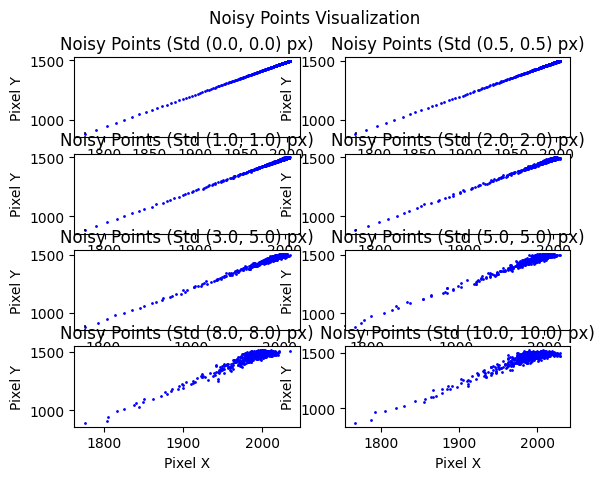

In [45]:
np.random.seed(0)

calibrations_by_stds = []
stds = [
    (0.0, 0.0),
    (0.5, 0.5),
    (1.0, 1.0),
    (2.0, 2.0),
    (3.0, 5.0), # Real world estimate
    (5.0, 5.0),
    (8.0, 8.0),
    (10.0, 10.0),
]

fig, axs = plt.subplots(4, 2)
fig.suptitle('Noisy Points Visualization')

for idx, (x_std, y_std) in enumerate(tqdm(stds)):
    x, y = divmod(idx, 2)
    ax = axs[x, y]

    s_noisy = s.copy()
    s_noisy[0, :] += np.random.normal(0, x_std, s.shape[1])
    s_noisy[1, :] += np.random.normal(0, y_std, s.shape[1])

    rays = inverted_camera_intrinsics @ s_noisy
    scale_factor = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays)
    p_noisy = rays * scale_factor

    s_pixel_noisy = s_noisy.copy()
    s_pixel_noisy[0, :] += np.random.normal(0, x_std, s.shape[1])
    s_pixel_noisy[1, :] += np.random.normal(0, y_std, s.shape[1])
    s_pixel_noisy = np.round(s_pixel_noisy)

    rays_pixel = inverted_camera_intrinsics @ s_pixel_noisy
    scale_factor_pixel = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays_pixel)
    p_pixel_noisy = rays_pixel * scale_factor_pixel

    calibrations = []
    calibrations_pca = []
    calibrations_pixels = []
    calibrations_pca_pixels = []
    for n in tqdm(list(range(2, STEP_COUNT))):
        idxs = np.random.choice(np.arange(STEP_COUNT), n, replace=False)

        local_laser_origin, local_laser_orientation = calibrate_laser(p_noisy[:, idxs].T)
        calibration_noisy = np.concatenate([local_laser_orientation, local_laser_origin[:2]])
        
        local_laser_origin, local_laser_orientation = weighted_pca_calibration(s_noisy[:, idxs], p_noisy[:, idxs].T, camera_intrinsics, sigma_px=y_std, sigma_Z=0.1)
        calibration_pca = np.concatenate([local_laser_orientation, local_laser_origin[:2]])

        local_laser_origin_pixel, local_laser_orientation_pixel = calibrate_laser(p_pixel_noisy[:, idxs].T)
        calibration_pixel_noisy = np.concatenate([local_laser_orientation_pixel, local_laser_origin_pixel[:2]])

        local_laser_origin, local_laser_orientation = weighted_pca_calibration(s_pixel_noisy[:, idxs], p_pixel_noisy[:, idxs].T, camera_intrinsics, sigma_px=y_std, sigma_Z=0.1)
        calibration_pca_pixel_noisy = np.concatenate([local_laser_orientation, local_laser_origin[:2]])

        calibrations.append(calibration_noisy)
        calibrations_pca.append(calibration_pca)
        calibrations_pixels.append(calibration_pixel_noisy)
        calibrations_pca_pixels.append(calibration_pca_pixel_noisy)
    ax.set_title(f'Noisy Points (Std ({x_std}, {y_std}) px)')
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    ax.scatter(s_noisy[0, :], s_noisy[1, :], c='blue', s=1, label='Noisy Points')

    calibrations_by_stds.append(((x_std, y_std), calibrations, calibrations_pca, calibrations_pixels, calibrations_pca_pixels))

In [46]:
def pca_calibration(world_points: np.ndarray):
    x_bar = np.mean(world_points, axis=0)
    
    centered_points = np.tile(x_bar, (world_points.shape[0], 1)) - world_points
    covariance_matrix = centered_points.T @ centered_points
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]

    laser_direction = principal_axis / np.linalg.norm(principal_axis)
    laser_position = x_bar.flatten()

    scale_factor = x_bar[2] / laser_direction[2]
    laser_position = laser_position - scale_factor * laser_direction
    # laser_position[2] = 0.0

    return laser_position, laser_direction

In [47]:
def point_covariance_from_uvZ(u, v, Z, K, sigma_px=1.0, sigma_Z=0.01):
    """
    Approximate 3D covariance Sigma_X for each point from pixel + depth noise.
    sigma_px: pixel std (assumed isotropic in u,v)
    sigma_Z : depth std in same units as Z (meters, etc.)

    Returns Sigmas: (N,3,3)
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    x = (u - cx) / fx
    y = (v - cy) / fy

    N = len(Z)
    Sigmas = np.zeros((N, 3, 3), dtype=float)

    for i in range(N):
        Zi = Z[i]
        xi, yi = x[i], y[i]

        # Jacobians dX/du, dX/dv, dX/dZ for X=[xZ, yZ, Z]
        Ju = np.array([Zi / fx, 0.0, 0.0])
        Jv = np.array([0.0, Zi / fy, 0.0])
        Jz = np.array([xi, yi, 1.0])

        Sigma = (sigma_px**2) * (np.outer(Ju, Ju) + np.outer(Jv, Jv)) + (sigma_Z**2) * np.outer(Jz, Jz)
        Sigmas[i] = Sigma

    return Sigmas

def fit_line_weighted_pca(X, Sigmas, iters=3, eps=1e-12):
    """
    Practical approximation:
      - compute a scalar weight per point from its 3D covariance (smaller uncertainty -> higher weight)
      - run weighted PCA
      - iterate a couple times (weights depend weakly on pose; this just stabilizes)

    Returns P,D,t,weights
    """
    P = X.mean(axis=0)
    D = np.array([0, 0, 1.0], dtype=float)

    for _ in range(iters):
        # scalar uncertainty proxy: trace
        tr = np.trace(Sigmas, axis1=1, axis2=2)
        w = 1.0 / np.maximum(tr, eps)

        wsum = w.sum()
        P = (w[:, None] * X).sum(axis=0) / wsum
        Y = X - P

        # weighted covariance
        S = (Y * w[:, None]).T @ Y
        eigvals, eigvecs = np.linalg.eigh(S)
        D = eigvecs[:, np.argmax(eigvals)]
        D = D / np.linalg.norm(D)

    scale_factor = P[2] / D[2]
    P = P - scale_factor * D

    t = (X - P) @ D
    return P, D, t, w


In [48]:
laser_position, laser_direction

(array([-0.04, -0.11,  0.  ]), array([1.e-10, 1.e-10, 1.e+00]))

In [49]:
pca_calibration(p_noisy.T)

(array([0.00661677, 0.00573477, 0.        ]),
 array([-0.00282704, -0.00716713,  0.99997032]))

In [50]:
Sigmas = point_covariance_from_uvZ(s_noisy[0, :], s_noisy[1, :], p_noisy[2, :], camera_intrinsics, sigma_px=3.0, sigma_Z=0.01)
P, D, _, _ = fit_line_weighted_pca(p_noisy.T, Sigmas)

P, D

(array([-0.04035433, -0.10639026,  0.        ]),
 array([ 2.42978819e-05, -3.60496994e-04,  9.99999935e-01]))

In [51]:
calibrate_laser(p_noisy.T)

(array([-0.03132603, -0.0871713 ,  0.        ]),
 array([-3.30534793e-04, -1.05423410e-03,  9.99999404e-01]))

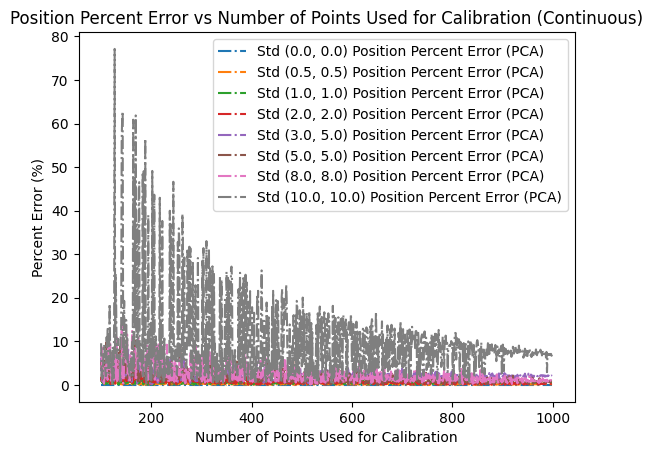

In [52]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _, _ in calibrations_by_stds],
    "PCA/dashdot": [(std, arrays) for std, _, arrays, _, _ in calibrations_by_stds],
}, laser_params, STEP_COUNT, "Continuous", start=100)

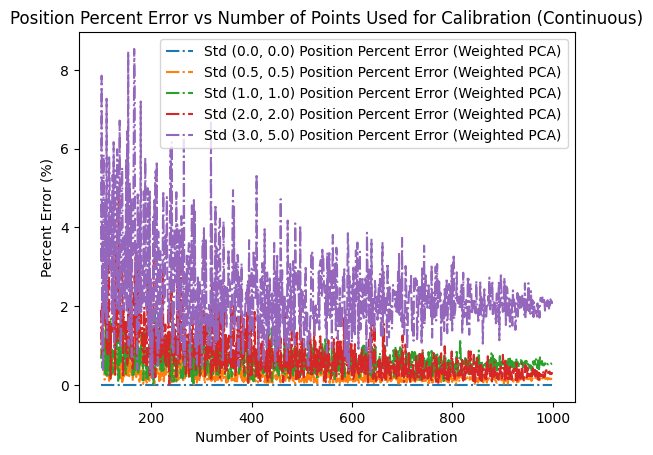

In [53]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _, _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _, _ in calibrations_by_stds[:5]],
}, laser_params, STEP_COUNT, "Continuous", start=100)

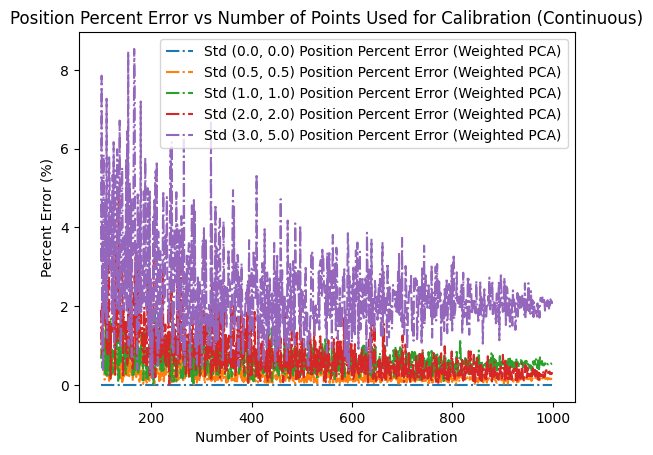

In [54]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _, _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _, _ in calibrations_by_stds[:5]],
}, laser_params, STEP_COUNT, "Continuous", start=100)

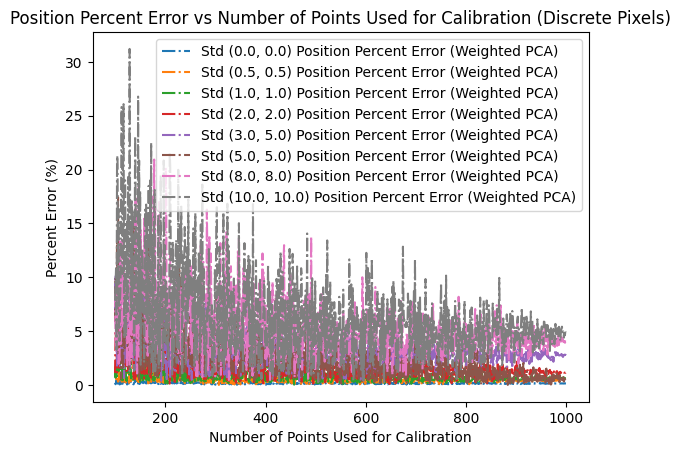

In [55]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays, _ in calibrations_by_stds],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _, arrays in calibrations_by_stds],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

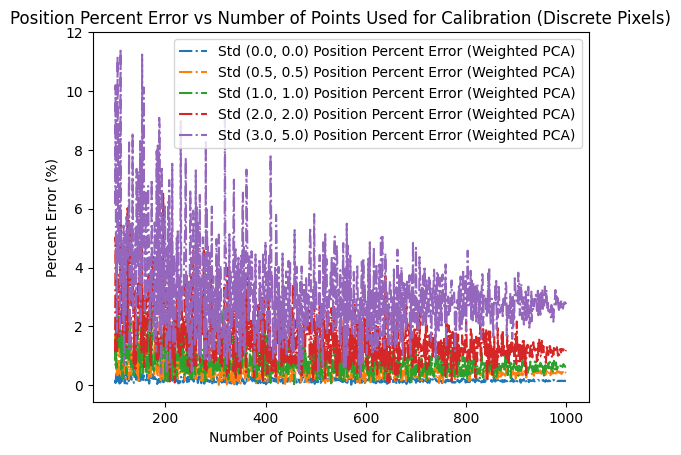

In [56]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays, _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _, arrays in calibrations_by_stds[:5]],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

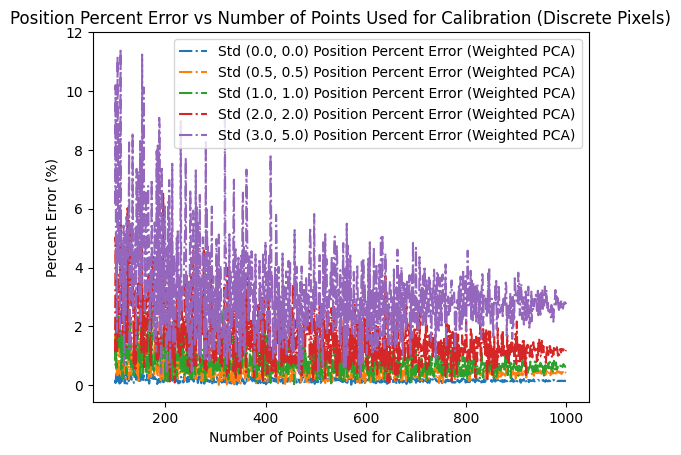

In [57]:
_ = calibration_plot_position_percent_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays, _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _, arrays in calibrations_by_stds[:5]],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

## Testing Each Calibration

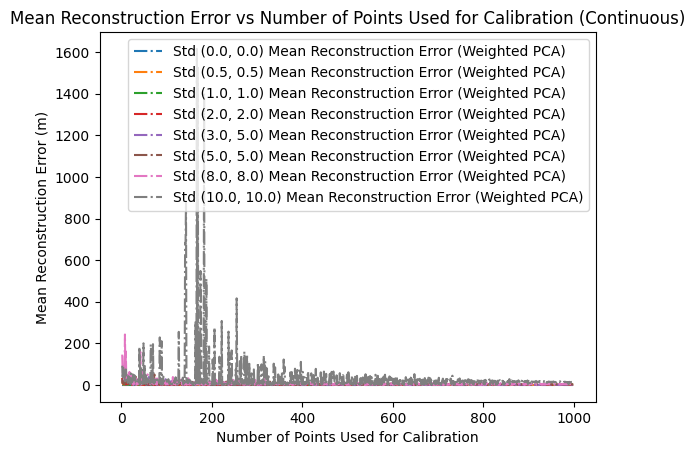

In [58]:
_ = calibration_plot_mean_reconstruction_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _,  _ in calibrations_by_stds],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _, _ in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous")

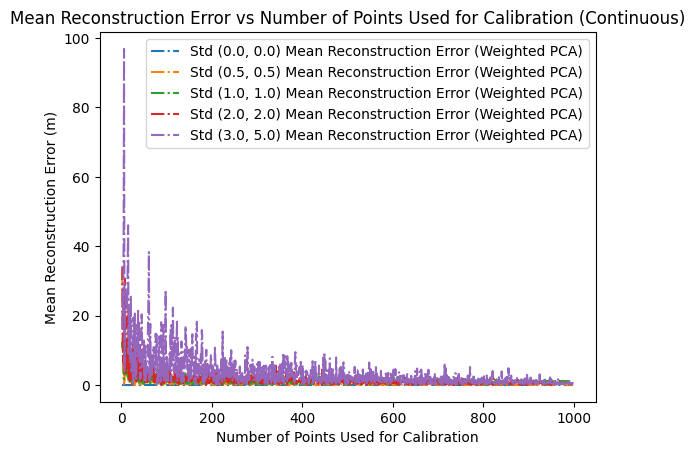

In [59]:
_ = calibration_plot_mean_reconstruction_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _,  _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _, _ in calibrations_by_stds[:5]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous")

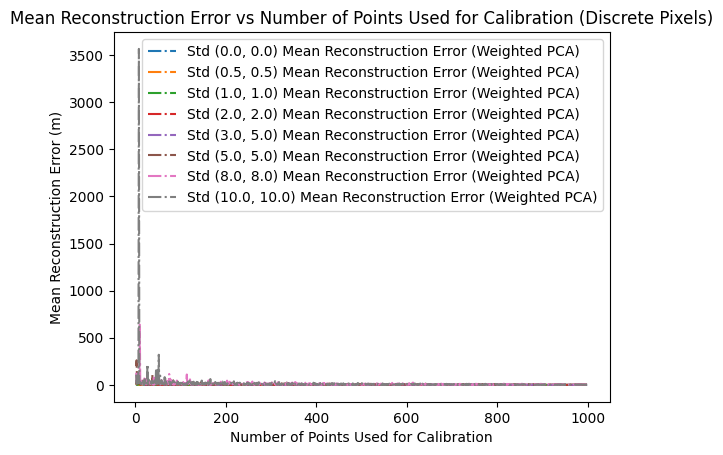

In [60]:
_ = calibration_plot_mean_reconstruction_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays,  _ in calibrations_by_stds],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _, arrays in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels")

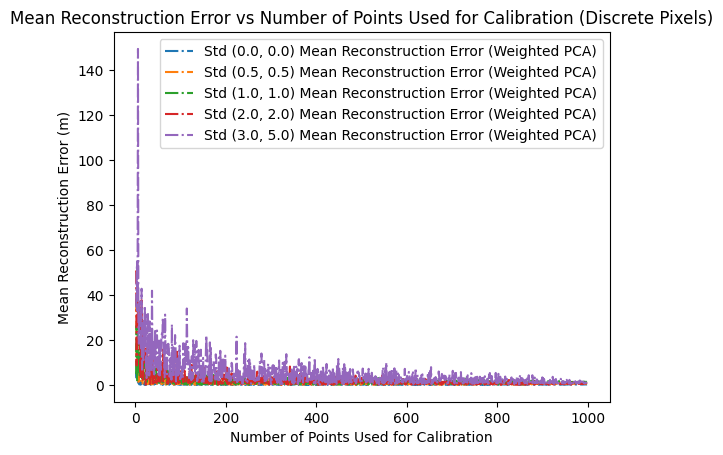

In [61]:
_ = calibration_plot_mean_reconstruction_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays,  _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _, arrays in calibrations_by_stds[:5]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels")

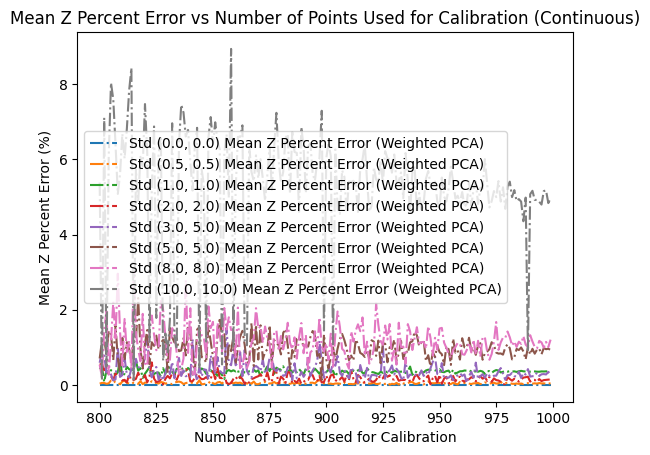

In [62]:
_ = calibration_plot_mean_z_percent_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _,  _ in calibrations_by_stds],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _,  _ in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous", start=800)

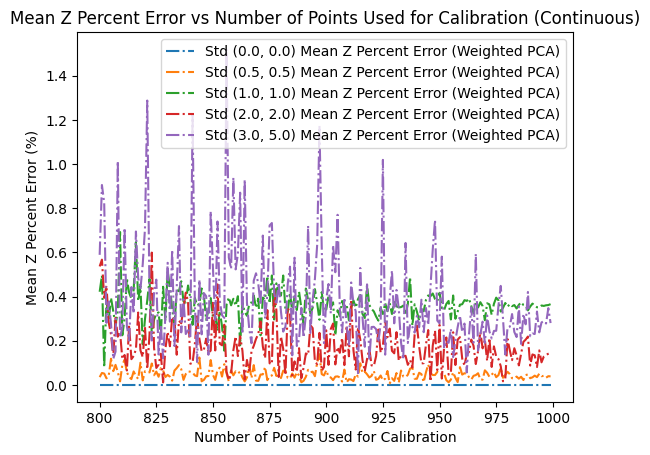

In [63]:
_ = calibration_plot_mean_z_percent_error({
    # "Original/solid": [(std, arrays) for std, arrays, _, _,  _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, arrays, _,  _ in calibrations_by_stds[:5]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous", start=800)

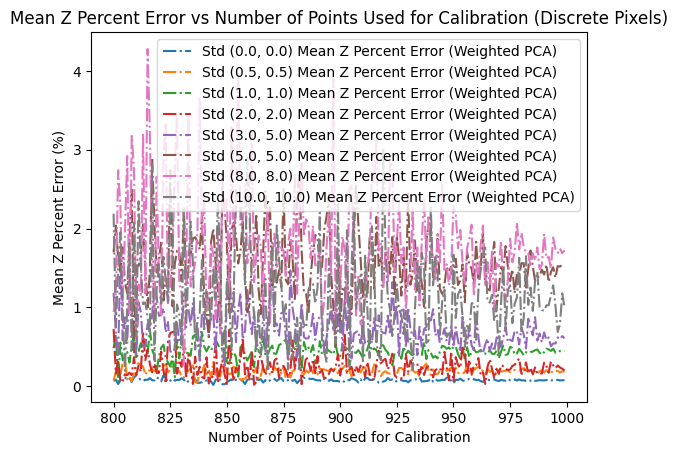

In [64]:
_ = calibration_plot_mean_z_percent_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays,  _ in calibrations_by_stds],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _,  arrays in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels", start=800)

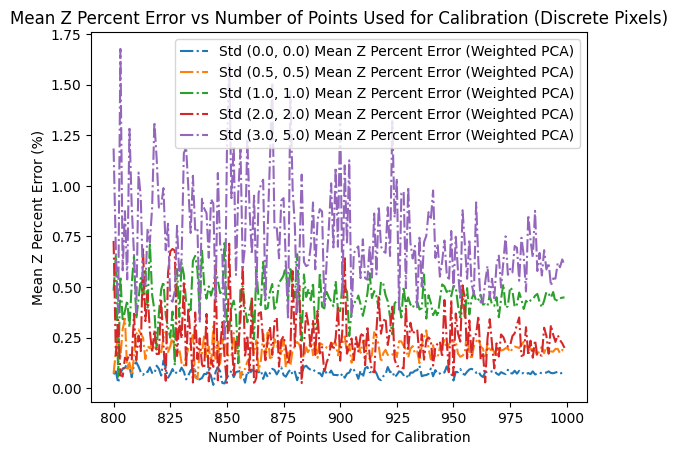

In [65]:
_ = calibration_plot_mean_z_percent_error({
    # "Original/solid": [(std, arrays) for std, _, _, arrays,  _ in calibrations_by_stds[:5]],
    "Weighted PCA/dashdot": [(std, arrays) for std, _, _, _,  arrays in calibrations_by_stds[:5]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels", start=800)